Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Cyclone IDAI Data

In [ ]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/cyclone_idai_2019_train.tsv"
dev_path = "/content/cyclone_idai_2019_dev.tsv"
test_path = "/content/cyclone_idai_2019_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [ ]:
train_df

,tweet_id,tweet_text,class_label
0,1107353602434183169,Maybe armchair critics like @lilomatic can app...,caution_and_advice
1,1108735335733825536,RT @povozim: Total Zimbabwe on the fuel situat...,other_relevant_information
2,1107658470508191744,.@Emuia briefed Mr Cho Jaichel on the coordina...,sympathy_and_support
3,1113073066131800064,Disease outbreaks: INGC maps potential risk ar...,caution_and_advice
4,1108234590068637696,Goodmorning to you all a smile will brighten s...,sympathy_and_support
...,...,...,...
3149,1106955852068605954,#CycloneIdai update: Chimanimani Rural Distric...,rescue_volunteering_or_donation_effort
3150,1108312925092098048,"Ropafadzo and Kojo, students at Rock Of Ages J...",rescue_volunteering_or_donation_effort
3151,1110950447697686528,.@ZooBoise donates 50 cents of the price of ev...,rescue_volunteering_or_donation_effort
3152,1107531318555017216,The death toll from Tropical #CycloneIdai indu...,injured_or_dead_people


In [ ]:
test_df

,tweet_id,tweet_text,class_label
0,1110232031135449093,The CHURCH needs to be present in #CYCLONEIDAI...,requests_or_urgent_needs
1,1108434173994455040,#CycloneIdai has left a path of destruction fo...,rescue_volunteering_or_donation_effort
2,1108091171660812289,#CycloneIdai: With humanitarian emergency in M...,rescue_volunteering_or_donation_effort
3,1110904245056950272,We must not let these people suffer a second d...,other_relevant_information
4,1110584283448651777,3 boxes of clothes received from Mr &amp; Mrs ...,rescue_volunteering_or_donation_effort
...,...,...,...
774,1109426619624706051,The situation will get worse before it gets be...,infrastructure_and_utility_damage
775,1112704164486959106,"@afreximbank has announced a donation of $1,5 ...",rescue_volunteering_or_donation_effort
776,1110482615822413824,Video footage captured by NewsDay shows that d...,rescue_volunteering_or_donation_effort
777,1107244053010268160,President @edmnangagwa has cut short his trip ...,other_relevant_information


ALL DATA

In [ ]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,1869
sympathy_and_support,482
injured_or_dead_people,433
other_relevant_information,407
infrastructure_and_utility_damage,354
requests_or_urgent_needs,143
caution_and_advice,89
not_humanitarian,80
displaced_people_and_evacuations,57


Data Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [ ]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

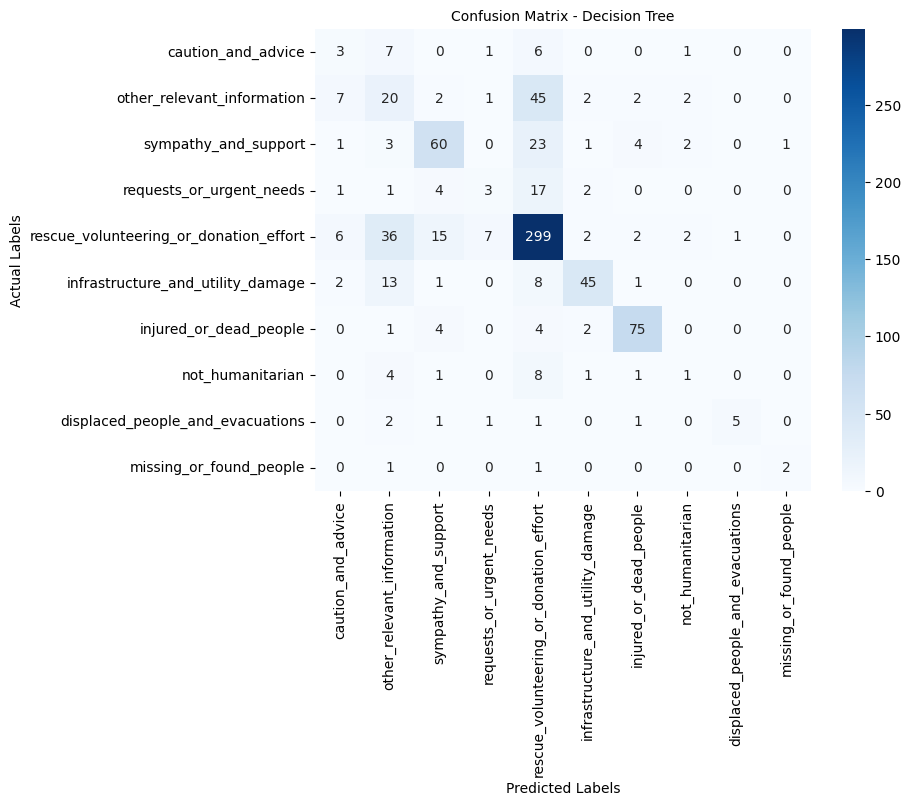


Decision Tree Evaluation:
Accuracy: 0.6585365853658537
Precision: 0.6507943963095577
F1 Score: 0.6506253634968509

 Classification Report:
                                        precision    recall  f1-score   support

                    caution_and_advice       0.15      0.17      0.16        18
            other_relevant_information       0.23      0.25      0.24        81
                  sympathy_and_support       0.68      0.63      0.66        95
              requests_or_urgent_needs       0.23      0.11      0.15        28
rescue_volunteering_or_donation_effort       0.73      0.81      0.76       370
     infrastructure_and_utility_damage       0.82      0.64      0.72        70
                injured_or_dead_people       0.87      0.87      0.87        86
                      not_humanitarian       0.12      0.06      0.08        16
      displaced_people_and_evacuations       0.83      0.45      0.59        11
               missing_or_found_people       0.67      0.50

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

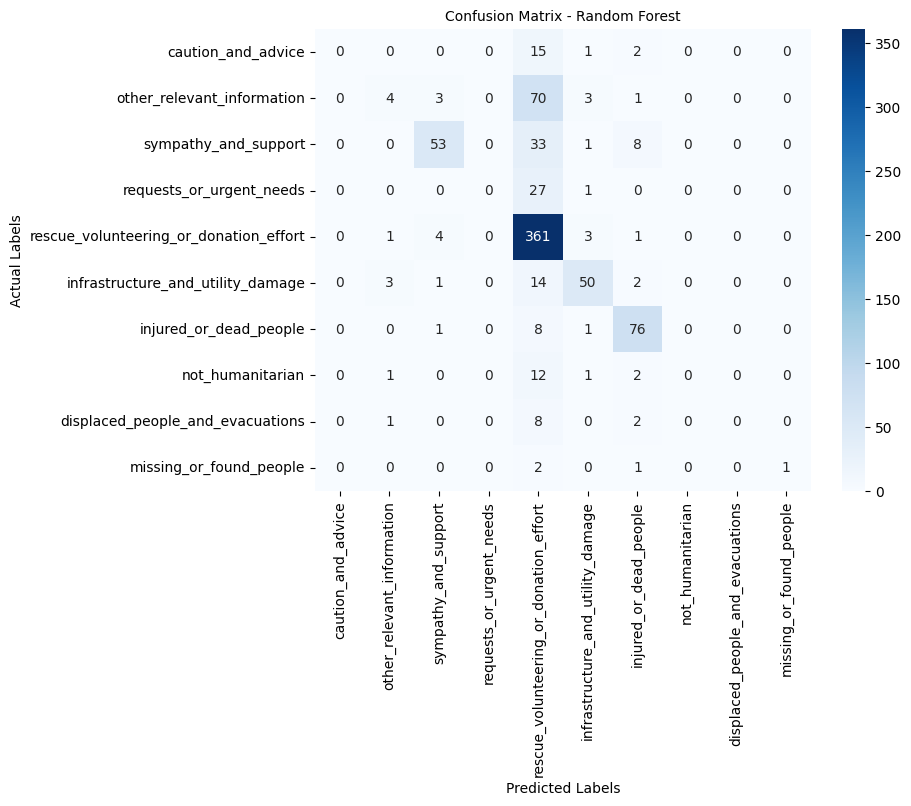


Random Forest Evaluation:
Accuracy: 0.699614890885751
Precision: 0.6246999641260952
F1 Score: 0.6275823885824909

 Classification Report:
                                        precision    recall  f1-score   support

                    caution_and_advice       0.00      0.00      0.00        18
            other_relevant_information       0.40      0.05      0.09        81
                  sympathy_and_support       0.85      0.56      0.68        95
              requests_or_urgent_needs       0.00      0.00      0.00        28
rescue_volunteering_or_donation_effort       0.66      0.98      0.78       370
     infrastructure_and_utility_damage       0.82      0.71      0.76        70
                injured_or_dead_people       0.80      0.88      0.84        86
                      not_humanitarian       0.00      0.00      0.00        16
      displaced_people_and_evacuations       0.00      0.00      0.00        11
               missing_or_found_people       1.00      0.25 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

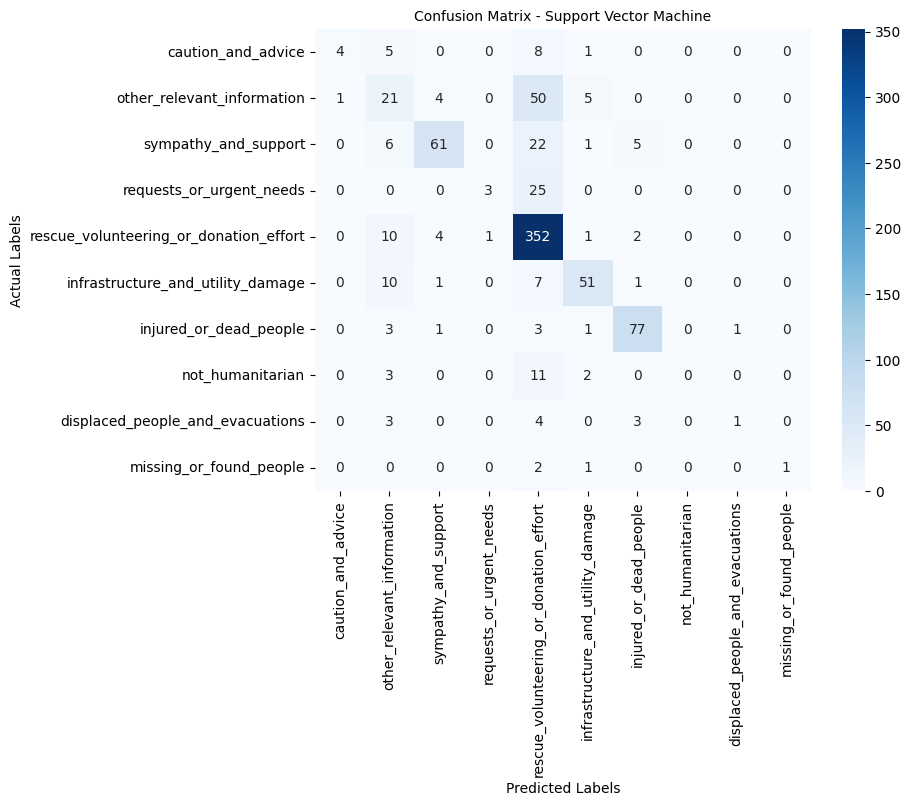


Support Vector Machine Evaluation:
Accuracy: 0.7329910141206675
Precision: 0.7129814377009939
F1 Score: 0.6975495038533468

 Classification Report:
                                        precision    recall  f1-score   support

                    caution_and_advice       0.80      0.22      0.35        18
            other_relevant_information       0.34      0.26      0.30        81
                  sympathy_and_support       0.86      0.64      0.73        95
              requests_or_urgent_needs       0.75      0.11      0.19        28
rescue_volunteering_or_donation_effort       0.73      0.95      0.82       370
     infrastructure_and_utility_damage       0.81      0.73      0.77        70
                injured_or_dead_people       0.88      0.90      0.89        86
                      not_humanitarian       0.00      0.00      0.00        16
      displaced_people_and_evacuations       0.50      0.09      0.15        11
               missing_or_found_people       1.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")